In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [2]:
#Plotting functions taken from the Tracr repo 

#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)

['BOS', '+', '+', '1', '3', '+']


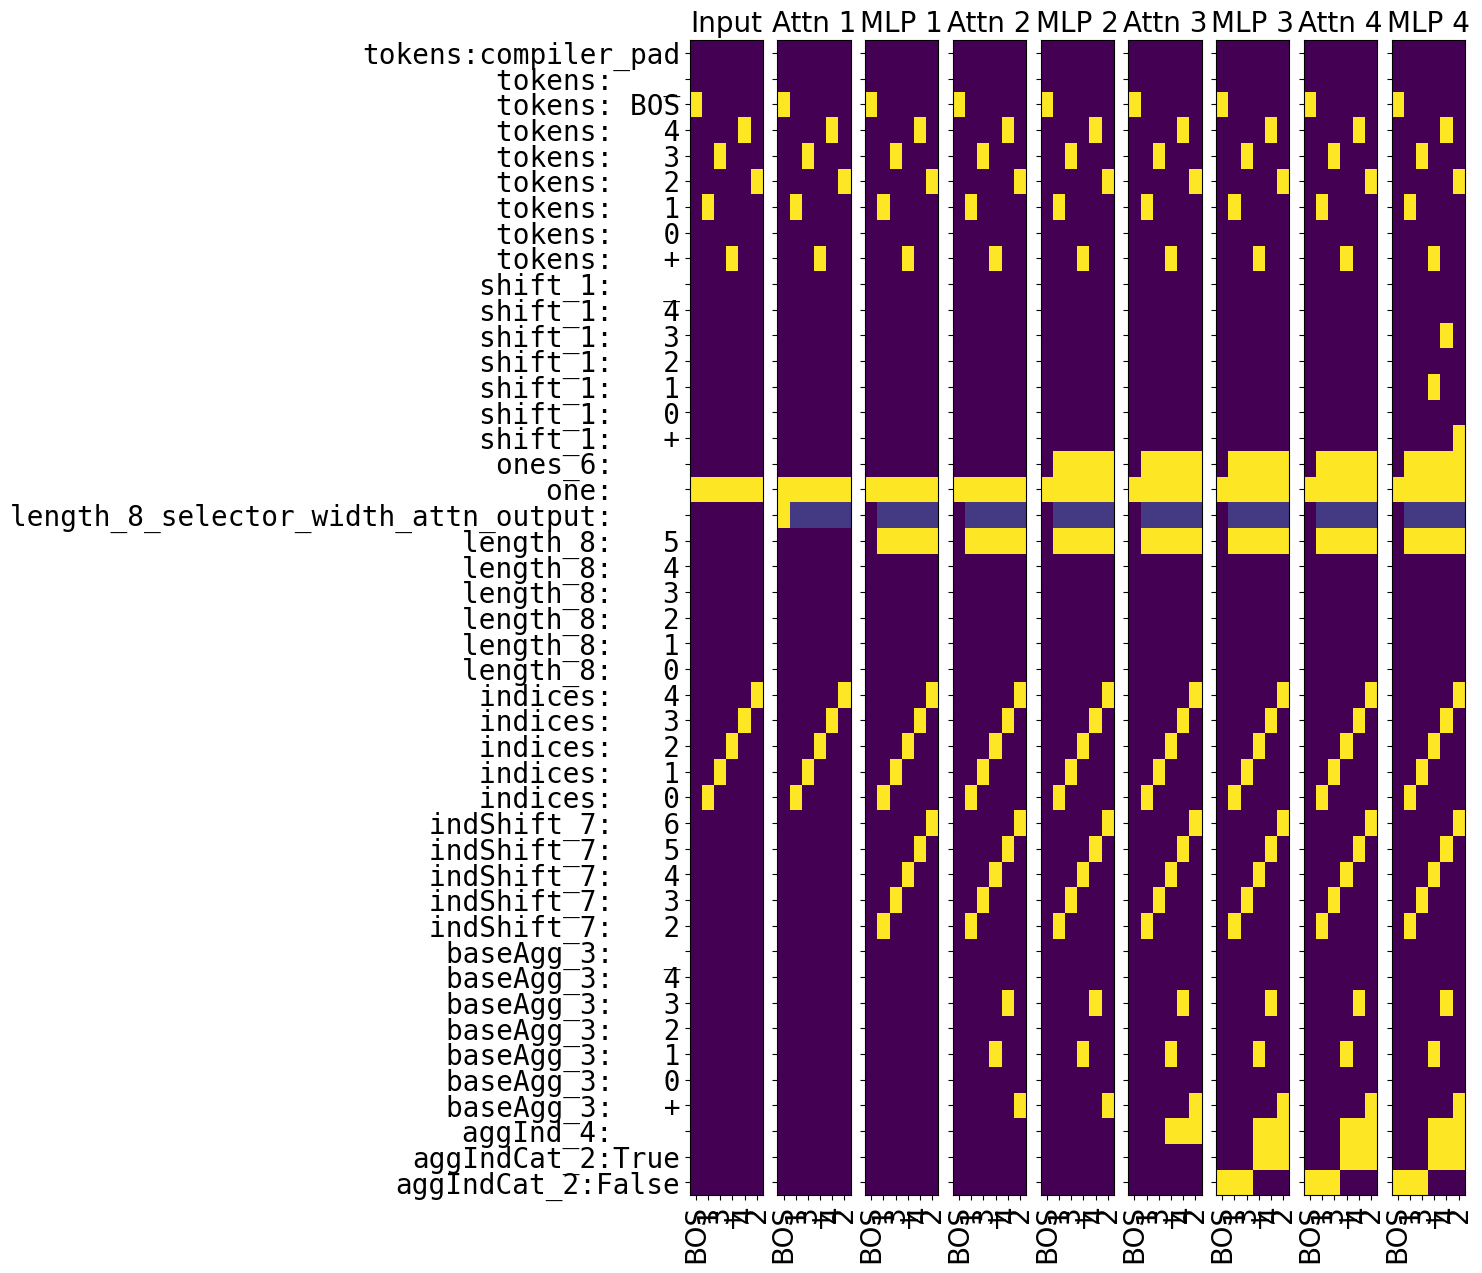

: 

In [3]:
#Since the default does not work in a useful way I made my own version
def defaultAggregate(sel: rasp.Selector, value: rasp.SOp, default="_") -> rasp.SOp:
    length = lib.make_length().named("length")
    ones = rasp.numerical(rasp.Map(lambda x: 1, length)).named("ones")
    aggInd = rasp.numerical(rasp.Aggregate(sel, ones, default=0)).named("aggInd")
    #Need to be categorical as SequenceMap only need both SOp to be same class
    #There seem to be major misscalculations in the actual value of aggInd since x>0.1 gives false results
    #   will likely lead to major bugs at some point (:
    aggIndCat = rasp.Map(lambda x: x > 0.5, aggInd).named("aggIndCat")
    baseAgg = rasp.Aggregate(sel, value).named("baseAgg")
    return rasp.SequenceMap(lambda x,y: y if x == True else default, aggIndCat, baseAgg).named("defaultAggregate")

#Shifts the sequence i steps to the right and fills with default token
def shift(i=1, default="_") -> rasp.SOp:
    indShift = (rasp.indices + i).named("indShift")
    shiftMask = rasp.Select(indShift, rasp.indices, rasp.Comparison.EQ).named("shiftMask")  
    #Implement manual default since Tracr does not seem to allow custom default tokens
    return defaultAggregate(shiftMask, rasp.tokens, default=default).named("shift")

    #A more efficient version which they use in rasp.lib
    #Circumvents the extra mlp (indShift) by adding directly in the Select function logic
    #select_off_by_offset = rasp.Select(rasp.indices, rasp.indices,
    #                                    lambda k, q: q == k + offset)
    #out = rasp.Aggregate(select_off_by_offset, sop, default=None)
    #return out.named(f"shift_by({offset})")

#Testing
shiftModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+","_"}, 5, compiler_bos="BOS")
#shiftModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+"}, 5, compiler_bos="BOS") #default,"_", needs to be included in the allowed input in order to be encoded correctly
model = shiftModel
input = ["BOS","1","3","+","4","2"]
print(model.apply(input).decoded)

plot_residuals_and_input(model=model, inputs=input, figsize=(10, 15))

#plot_layer_outputs(model=model, inputs=input, figsize=(10, 9))